In [22]:
import numpy as np
import h5py
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from encoder import Grid
from config import SENSOR_FL, labels_map, final_labels
import torch
import tqdm


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

# scene loader
data_path = r"C:\javier\personal_projects\ml\resources\RadarScenes\RadarScenes\data"
sequence_id = "sequence_1"
scene_fn = os.path.join(data_path, sequence_id, "scenes.json")

with open(scene_fn, "r") as f:
    json_data = json.load(f)
    sequence_name = json_data["sequence_name"]
    scenes = json_data["scenes"]
    first_timestamp = json_data["first_timestamp"]
    last_timestamp = json_data["last_timestamp"]
    timestamps = list(map(int, scenes.keys()))
    h5_filename = os.path.join(os.path.dirname(scene_fn), "radar_data.h5")

with h5py.File(h5_filename, "r") as f:
    radar_data = f["radar_data"][:]
    odometry_data = f["odometry"][:]


# filter detections by sensor
detections = radar_data[radar_data['sensor_id'] == SENSOR_FL]
detections = detections[['timestamp', 'x_cc', 'y_cc', 'vr_compensated', 'rcs', 'label_id']]
timestamps = np.unique(detections['timestamp'])
detections = pd.DataFrame(detections)

# map labels and filtering labels
for k, v in labels_map.items():
    detections.loc[detections['label_id'] == k, 'label_id'] = v
detections = detections[detections['label_id'].isin(final_labels)]

# saveing data per cycle
timestamps = np.unique(detections['timestamp'])
for ts in tqdm.tqdm(timestamps):
    cur_dets = detections[detections['timestamp'] == ts]

    # creating input and output grids
    grid_fl = Grid(x_lims=(2, 100), y_lims=(-50, 20), cell_size=0.5)
    grid_fl.fill_grid(cur_dets)
    grid_fl.fill_grid(cur_dets, is_output=True)

    filename = f"{sequence_id}_ts{ts}_fl.pt"

    input_data = torch.from_numpy(grid_fl.grid).permute(2, 0, 1)
    out_data = torch.from_numpy(grid_fl.out_grid).permute(2, 0, 1)

    torch.save(input_data, os.path.join("data/input", filename))
    torch.save(out_data, os.path.join("data/gt", filename))

100%|██████████| 1165/1165 [00:20<00:00, 57.46it/s]


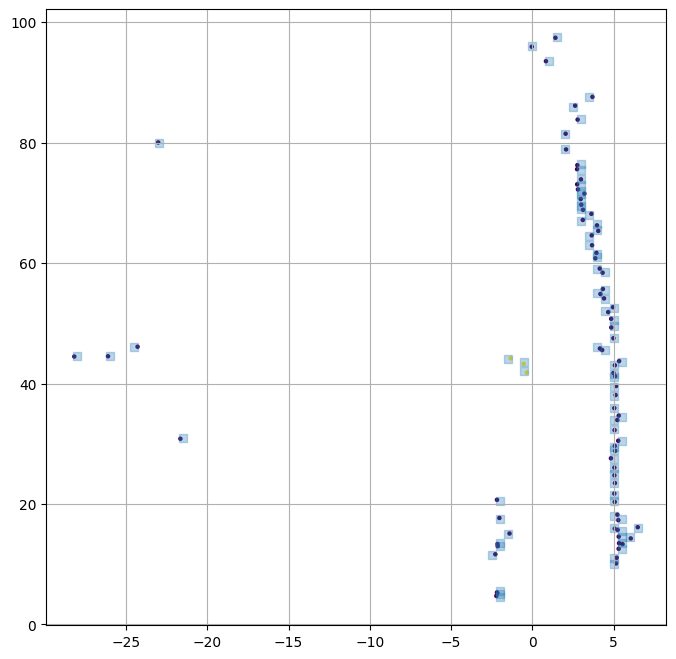

In [ ]:
from config import label_to_index, CAR

# inspecting grid
_ ,_ , x_pos, y_pos = grid_fl.get_active_cells_positions()
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(cur_dets['y_cc'], cur_dets['x_cc'], c=cur_dets['vr_compensated'], s=5)
ax.scatter(y_pos, x_pos, alpha=0.3, marker='s')
ax.grid()

x_inds, y_inds = np.where(grid_fl.out_grid[:, :, label_to_index[CAR]] > 0)
x_pos = x_inds * grid_fl.cell_size + grid_fl.x_lims[0]
y_pos = y_inds * grid_fl.cell_size + grid_fl.y_lims[0]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(cur_dets['y_cc'], cur_dets['x_cc'], c=cur_dets['vr_compensated'], s=5)
ax.scatter(y_pos, x_pos, alpha=0.3, marker='s')
ax.grid()

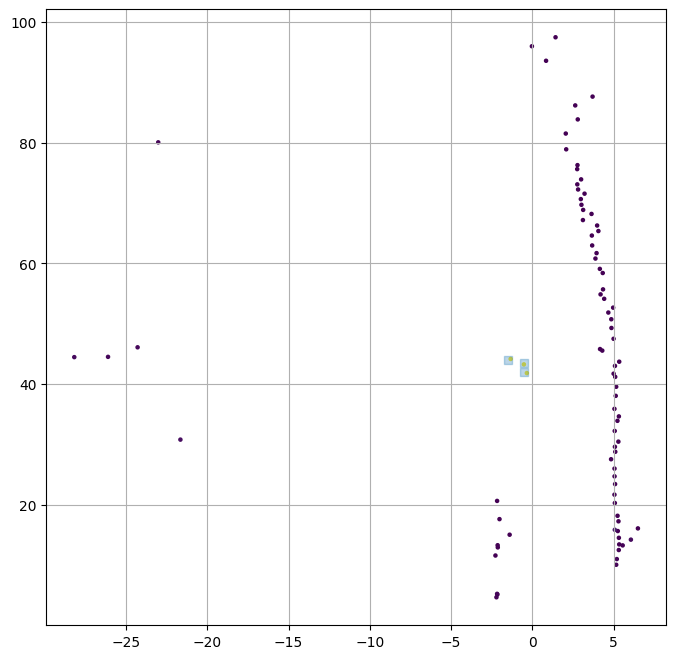